In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import numpy.linalg as LA
from sklearn import datasets, svm, metrics

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Connect GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/CSC2515_Project/data/out

test  train  valid


In [ ]:
# setting data paths
ROOT = "gdrive/MyDrive/CSC2515_Project/"
data = "gdrive/MyDrive/CSC2515_Project/data/out"

PCA


In [ ]:
from sklearn.decomposition import KernelPCA 
from PIL import Image

In [ ]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
      for file in filenames:
        if '.jpeg' in file:
          datalabel = dirpath.split('/')[-2]
          if (dirpath.split('/')[-1]=='normal'):
            classlabel = 0
          elif (dirpath.split('/')[-1]=='pneumonia'):
            classlabel = 1
          else:
            classlabel = 2
          imagelist.append((dirpath+'/'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [ ]:
#flatten images to array with additional preprocessing
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L') #Luminance or brightness 
        img = img.resize((128,128), Image.ANTIALIAS) #reshape 
        img = np.array(img)
        vmax = img.max()
        vmin = img.min()
        threshold = vmin + 0.9 * (vmax - vmin)
        _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        equalized = cv2.equalizeHist(img)
        vals.append(equalized)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 128 * 128), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        T[i] = trainlabel[idx[i]]
    return trainData,T

In [ ]:
train = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/train')
valid = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/valid')
test = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/test')

from sklearn.utils import shuffle

train = shuffle(train)
valid = shuffle(valid)
test = shuffle(valid)

print(train.shape)
print(valid.shape)
print(test.shape)

train['class'].unique()

(1892, 3)
(399, 3)
(399, 3)


array([1, 0, 2])

In [ ]:
X_train,Y_train = flatImages(train, selectedLabels=[0,1,2])
X_test,Y_test = flatImages(test, selectedLabels=[0,1,2])
X_valid,Y_valid = flatImages(valid, selectedLabels=[0,1,2])

Image Preprocessing - Exploratory


In [ ]:
X_valid_2d=X_valid.reshape(X_valid.shape[0],128,128)
X_train_2d=X_train.reshape(X_train.shape[0],128,128)
X_test_2d=X_test.reshape(X_test.shape[0],128,128)

In [ ]:
for i in range(X_valid_2d.shape[0]):
  x_sobel = ndimage.sobel(X_test_2d[i], axis=0)
  y_sobel = ndimage.sobel(X_test_2d[i], axis=1)

  xray_image_sobel = np.hypot(x_sobel, y_sobel)

  xray_image_sobel *= 255.0 / np.max(xray_image_sobel)

  fourier_gaussian = ndimage.fourier_gaussian(X_test_2d[i], sigma=0.05)

  x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
  y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)
  xray_image_canny = np.hypot(x_prewitt, y_prewitt)

  xray_image_canny *= 255.0 / np.max(xray_image_canny)
  X_test_2d[i] = xray_image_sobel.astype("float32")

In [ ]:
for i in range(X_train_2d.shape[0]):
  x_sobel = ndimage.sobel(X_train_2d[i], axis=0)
  y_sobel = ndimage.sobel(X_train_2d[i], axis=1)

  xray_image_sobel = np.hypot(x_sobel, y_sobel)

  xray_image_sobel *= 255.0 / np.max(xray_image_sobel)

  fourier_gaussian = ndimage.fourier_gaussian(X_train_2d[i], sigma=0.05)

  x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
  y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)
  xray_image_canny = np.hypot(x_prewitt, y_prewitt)

  xray_image_canny *= 255.0 / np.max(xray_image_canny)
  X_train_2d[i] = xray_image_sobel.astype("float32")


In [ ]:
for i in range(X_test_2d.shape[0]):
  x_sobel = ndimage.sobel(X_test_2d[i], axis=0)
  y_sobel = ndimage.sobel(X_test_2d[i], axis=1)

  xray_image_sobel = np.hypot(x_sobel, y_sobel)

  xray_image_sobel *= 255.0 / np.max(xray_image_sobel)

  fourier_gaussian = ndimage.fourier_gaussian(X_test_2d[i], sigma=0.05)

  x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
  y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)
  xray_image_canny = np.hypot(x_prewitt, y_prewitt)

  xray_image_canny *= 255.0 / np.max(xray_image_canny)
  X_test_2d[i] = xray_image_sobel.astype("float32")

In [ ]:
from scipy import ndimage
xray_image = X_train[10].reshape(128,128)
xray_image_laplace_gaussian = ndimage.gaussian_laplace(xray_image, sigma=1)
x_ray_image_gaussian_gradient = ndimage.gaussian_gradient_magnitude(xray_image, sigma=2)

x_sobel = ndimage.sobel(xray_image, axis=0)
y_sobel = ndimage.sobel(xray_image, axis=1)

xray_image_sobel = np.hypot(x_sobel, y_sobel)

xray_image_sobel *= 255.0 / np.max(xray_image_sobel)
xray_image_sobel = xray_image_sobel.astype("float32")

fourier_gaussian = ndimage.fourier_gaussian(xray_image, sigma=0.05)

x_prewitt = ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = ndimage.prewitt(fourier_gaussian, axis=1)

xray_image_canny = np.hypot(x_prewitt, y_prewitt)

xray_image_canny *= 255.0 / np.max(xray_image_canny)

print("The data type - ", xray_image_canny.dtype)


The data type -  float64


In [ ]:
xray_image_mask_noisy = np.where(xray_image > 50, xray_image, 0)

In [ ]:
xray_image_mask_less_noisy = np.where(xray_image > 150, 1, 0)

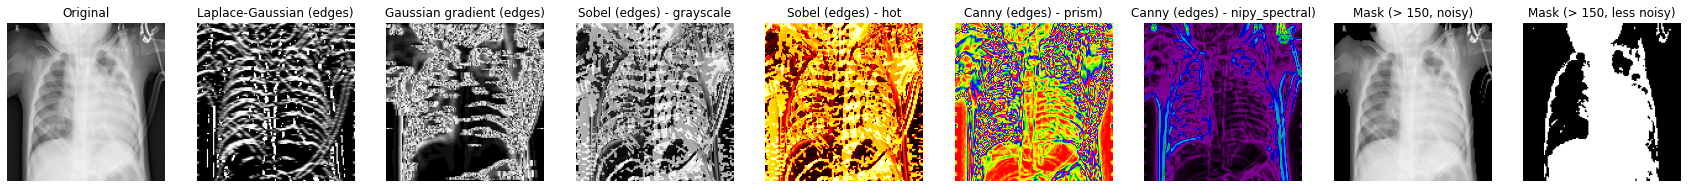

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(30, 30))

axes[0].set_title("Original")
axes[0].imshow(xray_image, cmap="gray")
axes[1].set_title("Laplace-Gaussian (edges)")
axes[1].imshow(xray_image_laplace_gaussian, cmap="gray")
axes[2].set_title("Gaussian gradient (edges)")
axes[2].imshow(x_ray_image_gaussian_gradient, cmap="gray")
axes[3].set_title("Sobel (edges) - grayscale")
axes[3].imshow(xray_image_sobel, cmap="gray")
axes[4].set_title("Sobel (edges) - hot")
axes[4].imshow(xray_image_sobel, cmap="hot")
axes[5].set_title("Canny (edges) - prism)")
axes[5].imshow(xray_image_canny, cmap="prism")
axes[6].set_title("Canny (edges) - nipy_spectral)")
axes[6].imshow(xray_image_canny, cmap="nipy_spectral")
axes[7].set_title("Mask (> 150, noisy)")
axes[7].imshow(xray_image_mask_noisy, cmap="gray")
axes[8].set_title("Mask (> 150, less noisy)")
axes[8].imshow(xray_image_mask_less_noisy, cmap="gray")
for i in axes:
    i.axis("off")
plt.show()

In [ ]:
X_train_l=X_train_2d.reshape(X_train_2d.shape[0],X_train_2d.shape[1]*X_train_2d.shape[2])
X_valid_l=X_valid_2d.reshape(X_valid_2d.shape[0],X_valid_2d.shape[1]*X_valid_2d.shape[2])
X_test_l=X_test_2d.reshape(X_test_2d.shape[0],X_test_2d.shape[1]*X_test_2d.shape[2])

In [ ]:
X_train_2d[1].shape

(128, 128)

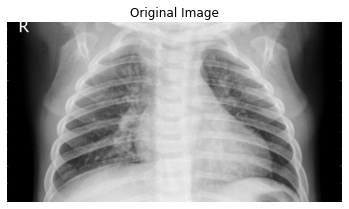

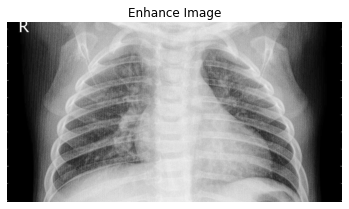

In [ ]:
import cv2
img = Image.open(valid.iloc[4].image)
img = img.convert('L')
img = np.array(img)

ret, img_gray = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size),np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
top = cv2.subtract(img, opening)

closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
bot = cv2.subtract(closing, img)

img_enh = cv2.subtract(cv2.add(img, top), bot)

plt.title("Original Image")
plt.axis(False)
plt.imshow(img, cmap='gray')
plt.show()

plt.title("Enhance Image")
plt.axis(False)
plt.imshow(img_enh, cmap='gray')
plt.show()

        

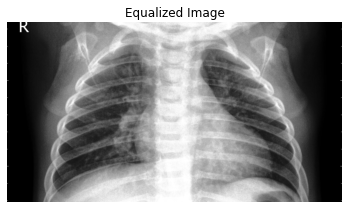

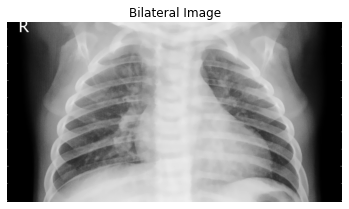

In [ ]:
img = Image.open(valid.iloc[4].image)
img = img.convert('L')
img = np.array(img)

vmax = img.max()
vmin = img.min()
threshold = vmin + 0.9 * (vmax - vmin)

_, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

equalized = cv2.equalizeHist(img)
plt.title("Equalized Image")
plt.axis(False)
plt.imshow(equalized, cmap='gray')
plt.show()

bilateral = cv2.bilateralFilter(img, 20, 9, 9)

plt.title("Bilateral Image")
plt.axis(False)
plt.imshow(bilateral, cmap='gray')
plt.show()


PCA

In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])

In [ ]:
X_valid=X_valid.reshape(X_valid.shape[0],X_valid.shape[1]*X_valid.shape[2])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

In [ ]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# PCA 
Z = scale(X_train) # standardize the data
pca = PCA(n_components=1024, random_state=2515)
projected_X_train = pca.fit_transform(X_train)

In [ ]:
projected_X_valid = pca.transform(X_valid)
projected_X_test = pca.transform(X_test)

In [ ]:
approximate_X_train = pca.inverse_transform(projected_X_train)

In [ ]:
approximate_X_train = approximate_X_train.reshape(-1,128,128)

Sanity Check

*Original*

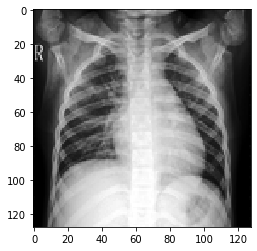

In [ ]:
plt.imshow((X_train[5]).reshape(128,128),interpolation = 'None', cmap = 'gray')

*Inverse Transformed*

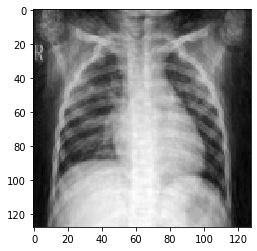

In [ ]:
plt.imshow((approximate_X_train[5]).reshape(128,128),interpolation = 'None', cmap = 'gray')

In [ ]:
X_train.shape

(1892, 16384)

In [ ]:
projected_X_train.shape

(1892, 1600)

(array([0, 1, 2], dtype=uint8), array([ 238, 1493,  161]))

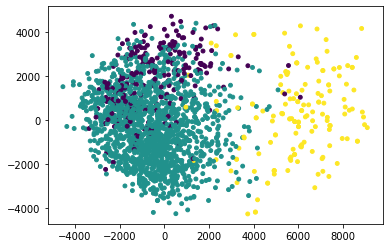

In [ ]:
plt.scatter(projected_X_train[:, 0], projected_X_train[:, 1], s = 15,
          c = Y_train)

np.unique(Y_train, return_counts=True)